#        Did financial crisis 2008-2009 impact on EU firms' capital structures?

### This document intends to provide source codes in order to replicate the analysis with different dataset
Owner: Trang Ton

Dataset used in this study is from Osiris Database. Due to different data sources, data cleaning steps might be different.

The regression analysis is not comprehensive and might ignore other financial factors that could impact the firms' capital structures. However, I hope this would give you prior ideas for further research.

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from docx import Document
from statsmodels.iolib.summary2 import summary_col
from linearmodels.panel import PanelOLS # using for panel regression
from linearmodels.panel import compare # creating combined table of results - panel analysis

In [2]:
DATA_FILE = '# Data path'
df = pd.read_csv(DATA_FILE, encoding = 'input file encoding')
df.head()

,Company name,Country - (address of incorp.),GICS code,GICS description,Net Income m EUR 2012,Net Income m EUR 2010,Net Income m EUR 2011,Net Income m EUR 2009,Net Income m EUR 2008,Net Income m EUR 2007,...,Net profit margin % Last avail. yr,Net profit margin % 2012,Net profit margin % 2011,Net profit margin % 2010,Net profit margin % 2009,Net profit margin % 2008,Net profit margin % 2007,Net profit margin % 2006,Net profit margin % 2005,Net profit margin % 2004
0,DESENIO GROUP AB,SWEDEN,25504040,SPECIALTY STORES,NaN,NaN,NaN,NaN,NaN,NaN,...,4.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MATERNUS-KLINIKEN AG,GERMANY,35102020,HEALTH CARE FACILITIES,-9.0,-70.0,-2.0,-72.0,-73.0,-70.0,...,-2.23,-7.55,-1.70,-62.97,-64.13,-66.68,-66.17,-30.11,9.71,-13.84
2,HOMECHOICE INTERNATIONAL P.L.C.,MALTA,25504060,HOMEFURNISHING RETAIL,25.0,NaN,23.0,NaN,NaN,NaN,...,19.13,33.81,35.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LPKF LASER & ELECTRONICS SE,GERMANY,45203010,ELECTRONIC EQUIPMENT & INSTRUMENTS,14.0,12.0,10.0,5.0,2.0,4.0,...,1.34,11.75,10.92,14.94,9.24,3.99,9.16,9.99,8.66,3.69
4,K-FAST HOLDING AB,SWEDEN,60201020,REAL ESTATE,NaN,NaN,NaN,NaN,NaN,NaN,...,236.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1. Transforming into panel data

The dataset is extracted from Osiris database. Afer exporting raw data from Osiris, transforming into panel setting.

In [3]:
### Change column names before transforming

# Loop to drop 'm EUR' in variable names
COL = list(df.columns)
dic = dict()
label = ' m EUR '
for col in COL:
    if label in col:
        new_name = col.replace(label, '')
        dic[col] = new_name
df = df.rename(columns = dic)

# Loop to drop ' % ' in variable names
COL = list(df.columns)
dic = dict()
label = ' % '
for col in COL:
    if label in col:
        new_name = col.replace(label, '')
        dic[col] = new_name
df = df.rename(columns = dic)


# Drop columns with 'Last avail. yr' terms
COL = list(df.columns)
label_drop = 'Last avail. yr'
for col in COL:
    if label_drop in col:
        df = df.drop(columns = col)
        
# Rename Number of employees columns
COL = list(df.columns)
dic = dict()
label = '.1'
for col in COL:
    if label in col:
        new_name = col.replace(label, '')
        dic[col] = new_name
df = df.rename(columns = dic)

# Rename Number of employees columns
COL = list(df.columns)
dic = dict()
label = 'Number of employees  '
for col in COL:
    if label in col:
        new_name = col.replace(label, 'Number of employees')
        dic[col] = new_name
df = df.rename(columns = dic)

#remove duplicate columns
duplicated_columns = df.columns.duplicated()

df = df.loc[:, ~duplicated_columns]

df.head()


,Company name,Country - (address of incorp.),GICS code,GICS description,Net Income2012,Net Income2010,Net Income2011,Net Income2009,Net Income2008,Net Income2007,...,Return on invested capital (ROIC)2004,Net profit margin2012,Net profit margin2011,Net profit margin2010,Net profit margin2009,Net profit margin2008,Net profit margin2007,Net profit margin2006,Net profit margin2005,Net profit margin2004
0,DESENIO GROUP AB,SWEDEN,25504040,SPECIALTY STORES,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MATERNUS-KLINIKEN AG,GERMANY,35102020,HEALTH CARE FACILITIES,-9.0,-70.0,-2.0,-72.0,-73.0,-70.0,...,-1.03,-7.55,-1.70,-62.97,-64.13,-66.68,-66.17,-30.11,9.71,-13.84
2,HOMECHOICE INTERNATIONAL P.L.C.,MALTA,25504060,HOMEFURNISHING RETAIL,25.0,NaN,23.0,NaN,NaN,NaN,...,NaN,33.81,35.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LPKF LASER & ELECTRONICS SE,GERMANY,45203010,ELECTRONIC EQUIPMENT & INSTRUMENTS,14.0,12.0,10.0,5.0,2.0,4.0,...,7.47,11.75,10.92,14.94,9.24,3.99,9.16,9.99,8.66,3.69
4,K-FAST HOLDING AB,SWEDEN,60201020,REAL ESTATE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
### Transforming the data set inro panel setting

year_arr = list(range(2004, 2013))
year_arr

COL = list(df.columns)

df_final = pd.DataFrame()
df_array = []
for year in year_arr:
    
    df_yearly = pd.DataFrame()
    df_yearly['Company'] = df['Company name']
    df_yearly['Year'] = year
    df_yearly['Country'] = df['Country - (address of incorp.)']
    df_yearly['GICS'] = df['GICS code']
    df_yearly['GICS Description'] = df['GICS description']
    
    for col in COL:
        if (f'{year}') in col:
            var = col.replace(f'{year}', '')
            df_yearly[var] = df[col]
            
    df_final = pd.concat([df_final, df_yearly])

/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/1464775697.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_yearly[var] = df[col]
/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/1464775697.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_yearly[var] = df[col]
/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/1464775697.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/1464775697.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_yearly[var] = df[col]
/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/1464775697.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_yearly[var] = df[col]
/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/1464775697.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/1464775697.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_yearly[var] = df[col]
/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/1464775697.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_yearly[var] = df[col]
/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/1464775697.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

In [5]:
### drop duplicated column Total Assets

df_final=df_final.drop(columns='Total Assets')

### Sort dataframe by company names and years
df_sort = df_final.sort_values(by=['Company', 'Year'])

In [6]:
### Export Panel dataset and save as csv file

df_sort.to_csv('raw_EU27_panel.csv', index=False)

# 2. Data Preparation

### Applying cleaning functions, categorizing functions

1. Cleaning functions: Replace missing value, modifying data types, classify industries, etc.

In [7]:
# Listing all used variables

EU19_list = ['AUSTRIA','BELGIUM','CYPRUS','ESTONIA','FINLAND',
             'FRANCE','GERMANY','GREECE','IRELAND','ITALY','LATVIA','LITHUANIA',
             'LUXEMBOURG','MALTA','NETHERLANDS','PORTUGAL','SLOVAKIA','SLOVENIA','SPAIN']

var_list = ['Total assets', 'Net sales','Total liabilities',
            'Market Cap.', 'ROA', 'Net debt',
           'Number of employees', 'Intangible assets']
non_missing_col = ['Total assets', 'Net sales','Total liabilities', 'Market Cap.']
positive_col = ['Total assets', 'Net sales','Total liabilities']
non_zero_col = ['Total assets', 'Net sales','Total liabilities', 'Market Cap.']
excluded_industries = ['Financials']

dtype_dic = {'Total assets': 'int64',
             'Net sales': 'int64',
             'Total liabilities': 'int64',
            'Market Cap.': 'int64'}

rename_dic = {'Return on assets (ROA)': 'ROA',
             'Number of employees ': 'Number of employees'}



In [8]:
# Function_1 to clean missing values and change data types

def dataframe_cleaning(df, non_missing_col, positive_col, non_zero_col, dtype_dic):
    # missing value filter
    df = df.dropna(subset = non_missing_col)
    
    # dropping duplicate values
    df = df.drop_duplicates(subset = ['Company', 'Year'])
    
    # fix datatypes
    df = df.astype(dtype_dic)
    
    # filter for insolvency
    for col in positive_col:
        df = df.loc[df[col] > 0]
        
    #filter for non zero values
    for col in non_zero_col:
        df = df.loc[df[col] != 0]
        
    return df
    

In [9]:
### Function_2 to classify industry

industry_dic = {'Energy': 10,
               'Materials': 15,
               'Industrials': 20,
               'Consumer Discretionary': 25,
               'Consumer Staples': 30,
               'Health Care': 35,
               'Financials': 40,
               'Information Technology': 45,
               'Communication Services': 50,
               'Utilities': 55,
               'Real Estate': 60}
def get_key_from_value(dictionary, value):
    for key in dictionary:
        if dictionary[key] == value:
            return key
    # If the value is not found, return None or raise an exception
    return None
def industry_classifier (GICS):
    industry = get_key_from_value(industry_dic,int(str(GICS)[:2]))
    return industry

In [10]:
### Function_3 to filter industries

def sample_filter(df, industry_col, excluded_industries):
    # filter for financial firms
    df = df.loc[~df[industry_col].isin(excluded_industries)]

    return df

In [11]:
### Function_4: Winsorization 

def winsorization(df, variables, lower_thresh = 0.01, upper_thresh = 0.99, by = 'Year', suffix = '_w'):
    dfs = []

    categories = df[by].unique()

    for cat in categories:
        df_cat = df.loc[df[by] == cat]

        for var in variables:
            df_cat[f'{var}{suffix}'] = df_cat[var].clip(lower = df_cat[var].dropna().quantile(lower_thresh),
                                                        upper = df_cat[var].dropna().quantile(upper_thresh))
        dfs.append(df_cat)

    df_output = pd.concat(dfs)
    
    return df_output

 2. Applying functions: import panel data, applying cleaning processes

In [12]:
# Import new raw panel
DATA_FILE = '/Users/tonnunhatrang/Desktop/Data analysis/Python/Essay_AMA3/EU27_raw_detailed/raw_EU27_panel.csv'
df = pd.read_csv(DATA_FILE, encoding = 'utf-8')
df.head()

,Company,Year,Country,GICS,GICS Description,Net Income,Market Cap.,Number of employees,Total current assets,Net inventory,...,Other after-tax adjustments,Extraordinary items after tax,Preferred dividends,Net profit,Ordinary dividends,Dividend share capital other,Return on assets (ROA),Return on equity (ROE),Return on invested capital (ROIC),Net profit margin
0,1&1 AG,2004,GERMANY,50102010,WIRELESS TELECOMMUNICATION SERVICES,11.0,80.0,369.0,50.0,8.0,...,NaN,NaN,NaN,11.0,NaN,NaN,9.77,19.39,32.11,3.02
1,1&1 AG,2005,GERMANY,50102010,WIRELESS TELECOMMUNICATION SERVICES,14.0,109.0,330.0,67.0,9.0,...,NaN,NaN,NaN,14.0,NaN,NaN,14.02,22.44,22.55,4.47
2,1&1 AG,2006,GERMANY,50102010,WIRELESS TELECOMMUNICATION SERVICES,17.0,139.0,304.0,38.0,6.0,...,NaN,NaN,NaN,17.0,0.0,NaN,9.51,18.78,42.77,6.09
3,1&1 AG,2007,GERMANY,50102010,WIRELESS TELECOMMUNICATION SERVICES,24.0,291.0,372.0,143.0,11.0,...,NaN,NaN,NaN,24.0,0.0,NaN,7.64,14.06,41.98,6.73
4,1&1 AG,2008,GERMANY,50102010,WIRELESS TELECOMMUNICATION SERVICES,-184.0,90.0,345.0,43.0,6.0,...,NaN,NaN,NaN,-184.0,0.0,NaN,-64.79,-138.71,-169.27,-52.58


In [13]:
### Applying cleaning processes
df = df.rename(columns = rename_dic)

df_clean = dataframe_cleaning(df, non_missing_col, positive_col, non_zero_col, dtype_dic)

# Apply function2 to dataframe, and create new column names Industry

df_clean['Industry'] = df['GICS'].apply(industry_classifier)

### Apply sample filter industries

df_clean = sample_filter(df_clean, industry_col = 'Industry', excluded_industries = excluded_industries)
df_clean

### Filtering Eurozone countries

EU19_data = df_clean[df_clean['Country'].isin(EU19_list)]
EU19_data

,Company,Year,Country,GICS,GICS Description,Net Income,Market Cap.,Number of employees,Total current assets,Net inventory,...,Extraordinary items after tax,Preferred dividends,Net profit,Ordinary dividends,Dividend share capital other,ROA,Return on equity (ROE),Return on invested capital (ROIC),Net profit margin,Industry
0,1&1 AG,2004,GERMANY,50102010,WIRELESS TELECOMMUNICATION SERVICES,11.0,80,369.0,50.0,8.0,...,NaN,NaN,11.0,NaN,NaN,9.77,19.39,32.11,3.02,Communication Services
1,1&1 AG,2005,GERMANY,50102010,WIRELESS TELECOMMUNICATION SERVICES,14.0,109,330.0,67.0,9.0,...,NaN,NaN,14.0,NaN,NaN,14.02,22.44,22.55,4.47,Communication Services
2,1&1 AG,2006,GERMANY,50102010,WIRELESS TELECOMMUNICATION SERVICES,17.0,139,304.0,38.0,6.0,...,NaN,NaN,17.0,0.0,NaN,9.51,18.78,42.77,6.09,Communication Services
3,1&1 AG,2007,GERMANY,50102010,WIRELESS TELECOMMUNICATION SERVICES,24.0,291,372.0,143.0,11.0,...,NaN,NaN,24.0,0.0,NaN,7.64,14.06,41.98,6.73,Communication Services
4,1&1 AG,2008,GERMANY,50102010,WIRELESS TELECOMMUNICATION SERVICES,-184.0,90,345.0,43.0,6.0,...,NaN,NaN,-184.0,0.0,NaN,-64.79,-138.71,-169.27,-52.58,Communication Services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32107,ZUMTOBEL GROUP AG,2008,AUSTRIA,20104010,ELECTRICAL COMPONENTS & EQUIPMENT,93.0,904,7708.0,505.0,162.0,...,-1.0,NaN,93.0,-31.0,NaN,8.26,19.49,20.65,7.25,Industrials
32108,ZUMTOBEL GROUP AG,2009,AUSTRIA,20104010,ELECTRICAL COMPONENTS & EQUIPMENT,13.0,313,7165.0,425.0,149.0,...,-10.0,NaN,13.0,-31.0,NaN,1.22,2.72,10.33,1.12,Industrials
32109,ZUMTOBEL GROUP AG,2010,AUSTRIA,20104010,ELECTRICAL COMPONENTS & EQUIPMENT,-67.0,711,7329.0,466.0,146.0,...,0.0,NaN,-67.0,-6.0,NaN,-6.60,-16.65,7.05,-6.02,Industrials
32110,ZUMTOBEL GROUP AG,2011,AUSTRIA,20104010,ELECTRICAL COMPONENTS & EQUIPMENT,51.0,1066,7814.0,503.0,190.0,...,-2.0,NaN,51.0,-29.0,NaN,5.09,13.97,16.28,4.15,Industrials


In [14]:
EU19_data[non_missing_col].isna().sum()

Total assets         0
Net sales            0
Total liabilities    0
Market Cap.          0
dtype: int64

In [15]:
EU19_data[var_list].isna().sum()

Total assets             0
Net sales                0
Total liabilities        0
Market Cap.              0
ROA                    252
Net debt                 0
Number of employees    862
Intangible assets      340
dtype: int64

In [16]:
EU19_data = EU19_data.replace(['na', 'nan', 'N/A', 'NA', 'NaN'], '')

In [17]:
### Replace missing values by Mean or zero (using for variables with small number of missing values compared to total obs)
values = {'ROA': EU19_data['ROA'].mean(),
         'Number of employees': 0,
         'Intangible assets': EU19_data['Intangible assets'].mean()}

df_replace_missing = EU19_data.fillna(value = values)
EU19_data = df_replace_missing
EU19_data[var_list].isna().sum()

Total assets           0
Net sales              0
Total liabilities      0
Market Cap.            0
ROA                    0
Net debt               0
Number of employees    0
Intangible assets      0
dtype: int64

## 4. Regression Analysis

### 1. Calculations

In [18]:
### Control variables

df = EU19_data

df['Net_assets'] = df['Total assets'] - df['Total liabilities']

### Firm size
df['log_Firm_size'] = np.log(df['Net sales'])

### Tangibility
df['Tangible_assets'] = df['Total assets'] - df['Intangible assets']
df['Tangibility'] = df['Tangible_assets'] / df['Total assets']

### Log transformmation of Market capitalization
df['log_MarketCap'] = np.log(df['Market Cap.'])

### Add constant parameter for regression estimation
df['const'] = 1


In [19]:
### Cleaning zero values after calucation

df = df.loc[df['Net_assets'] != 0]

In [20]:
### Leverage calculations

### Leverage ratio : calculated by Total liabilities / Total assets

df['Total_Leverage'] = df['Total liabilities'] / df['Total assets']

### Debt ratio: calculated by Net debt/ Net assets
df['Debt_leverage'] = df['Net debt'] / df['Net_assets']

Leverage_variables = ['Total_Leverage', 'Debt_leverage']

/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/2119322929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total_Leverage'] = df['Total liabilities'] / df['Total assets']
/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/2119322929.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Debt_leverage'] = df['Net debt'] / df['Net_assets']


In [21]:
df[['Debt_leverage', 'Net debt', 'Net_assets', 'Tangibility']].isna().sum()

Debt_leverage    0
Net debt         0
Net_assets       0
Tangibility      0
dtype: int64

In [22]:
### treating outlier by winzorization
winzorized_var = ['log_MarketCap', 'ROA', 'log_Firm_size', 'Tangibility', 'Total_Leverage', 'Debt_leverage']
df_w = winsorization(df, variables = winzorized_var, by = 'Year')

/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/3453492704.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[f'{var}{suffix}'] = df_cat[var].clip(lower = df_cat[var].dropna().quantile(lower_thresh),
/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/3453492704.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[f'{var}{suffix}'] = df_cat[var].clip(lower = df_cat[var].dropna().quantile(lower_thresh),
/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_163

### 2. Statistic description and visualization

In [23]:
df_industry = df['Industry'].unique()
Industry_data = pd.DataFrame()
num_company = []
for industry in df_industry:
    num = df_w.loc[df['Industry'] == f'{industry}']['Company'].nunique()
    num_company.append(num)
Industry_data['Industry'] =  df_industry
Industry_data['Number of Comapny'] = num_company
Industry_data

,Industry,Number of Comapny
0,Communication Services,104
1,Industrials,292
2,Health Care,94
3,Utilities,50
4,Consumer Discretionary,199
5,Real Estate,124
6,Materials,113
7,Consumer Staples,123
8,Information Technology,178
9,Energy,43


In [24]:
### Descriptive statistics table:

descriptive_table = df_w.groupby('Year').agg({'Total_Leverage_w': ['mean', 'std'], 'Debt_leverage_w': ['mean', 'std'],
                                              'log_MarketCap_w': ['mean', 'std'], 'ROA_w': ['mean', 'std'],
                                          'log_Firm_size_w': ['mean', 'std'], 'Tangibility_w': ['mean', 'std']})


descriptive_table

Total_Leverage_w           Debt_leverage_w           log_MarketCap_w  \
                 mean       std            mean       std            mean   
Year                                                                        
2004         0.595255  0.187398        0.541241  1.144250        5.391295   
2005         0.583126  0.188515        0.507425  0.974249        5.635377   
2006         0.576526  0.184415        0.531105  1.106527        5.805860   
2007         0.567327  0.186154        0.539618  1.097899        5.643762   
2008         0.591677  0.187487        0.795790  1.665538        4.938444   
2009         0.576392  0.193095        0.713108  1.674829        5.163694   
2010         0.570931  0.187842        0.635890  1.449890        5.250929   
2011         0.576927  0.193903        0.733017  1.809178        5.031103   
2012         0.575545  0.204730        0.548959  1.462090        5.087769   

                   ROA_w            log_Firm_size_w           Tangibility_w  \
           std      mean        std            mean       std          mean   
Year                                                                          
2004  2.190850  3.673279   7.942468        5.687309  2.194264      0.320686   
2005  2.212819  4.101866   7.699872        5.719844  2.261766      0.344273   
2006  2.208655  4.955692   8.514476        5.755720  2.267737      0.335311   
2007  2.156163  4.835690   8.408652        5.563353  2.270133     -0.198065   
2008  2.193359  1.741277  10.074860        5.640160  2.253618      0.068209   
2009  2.236352  0.579031   8.934647        5.502447  2.256439      0.230357   
2010  2.262487  2.645516   8.754958        5.535437  2.292046      0.184903   
2011  2.271369  2.223063   8.569271        5.579392  2.327880      0.515323   
2012  2.310005  1.462152   9.126341        5.560992  2.341323      0.180867   

                
           std  
Year            
2004  3.318307  
2005  3.173576  
2006  3.168094  
2007  7.150536  
2008  5.561053  
2009  4.408823  
2010  4.876074  
2011  2.221779  
2012  4.344591

In [25]:
OUTPUT_DIR = ''
OUTPUT_FILE_NAME = 'EU19_Descriptive_Table.xlsx'
descriptive_table.to_excel(f'{OUTPUT_DIR}{OUTPUT_FILE_NAME}', sheet_name = 'EU19 Stats')

/var/folders/h1/t56s_k9952x13x1w1hwkv_d40000gn/T/ipykernel_1636/2899841626.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  debt_leverage = pd.Series(index=years)


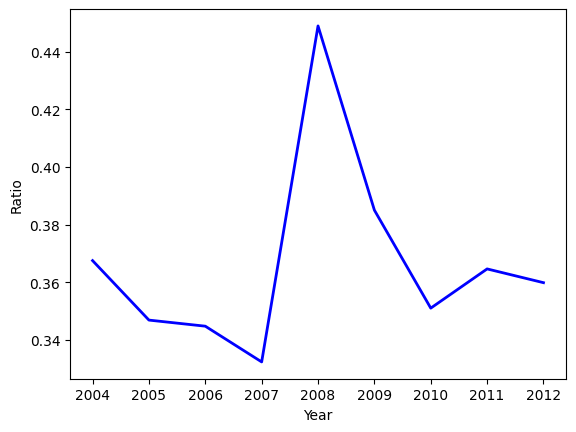

In [26]:
years = np.arange(2004, 2013)
debt_leverage = pd.Series(index=years)

for year in years:
    debt_leverage[year] = df_w.loc[df_w['Year'] == year, 'Debt_leverage_w'].median()
    
    
x = years


fig, ax = plt.subplots()
ax.plot(x, debt_leverage, 'b-', linewidth=2, label = 'Debt Leverage')

ax.set_xlabel('Year')
ax.set_ylabel('Ratio')


plt.show()

In [27]:
control_var = ['log_MarketCap_w', 'ROA_w', 'log_Firm_size_w', 'Tangibility_w']
corr_matrix = df_w[['Total_Leverage_w'] + ['Debt_leverage_w']+ control_var].corr()
corr_matrix

,Total_Leverage_w,Debt_leverage_w,log_MarketCap_w,ROA_w,log_Firm_size_w,Tangibility_w
Total_Leverage_w,1.000000,0.477778,0.118329,-0.249638,0.327356,0.092797
Debt_leverage_w,0.477778,1.000000,-0.015144,-0.149200,0.052042,0.025819
log_MarketCap_w,0.118329,-0.015144,1.000000,0.287477,0.854076,0.161590
ROA_w,-0.249638,-0.149200,0.287477,1.000000,0.229710,0.034834
log_Firm_size_w,0.327356,0.052042,0.854076,0.229710,1.000000,0.216254
Tangibility_w,0.092797,0.025819,0.161590,0.034834,0.216254,1.000000


<Axes: >

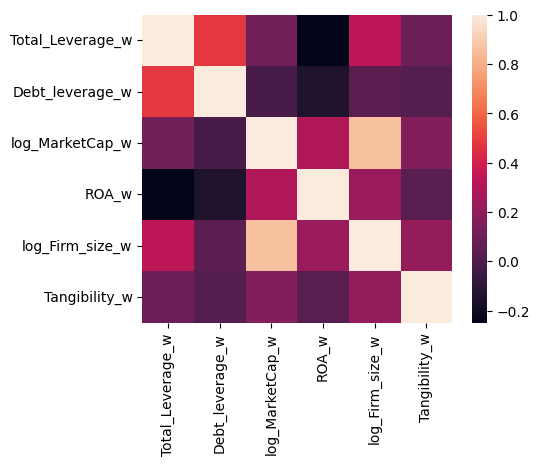

In [28]:
corr_list = ['Total_Leverage_w','Debt_leverage_w','log_MarketCap_w', 'ROA_w', 'log_Firm_size_w', 'Tangibility_w']
df_corr = df_w[corr_list]

plt.figure(figsize = (5,4))
sns.heatmap(df_corr.corr())

In [29]:
### How many companies are left (after cleaning missing values for main variables, and excluding financial industries)

unique_com = df_w['Company'].nunique()
unique_com


1320

In [30]:
### How many years:
unique_yr = df_w['Year'].unique()
unique_yr

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012])

In [31]:
### which countries are included:
unique_country = sorted(EU19_data['Country'].unique())
unique_country

['AUSTRIA',
 'BELGIUM',
 'CYPRUS',
 'ESTONIA',
 'FINLAND',
 'FRANCE',
 'GERMANY',
 'GREECE',
 'IRELAND',
 'ITALY',
 'LATVIA',
 'LITHUANIA',
 'LUXEMBOURG',
 'MALTA',
 'NETHERLANDS',
 'PORTUGAL',
 'SLOVAKIA',
 'SLOVENIA',
 'SPAIN']

In [32]:
### what industries ar included:
industries = sorted(EU19_data['Industry'].unique())
industries

['Communication Services',
 'Consumer Discretionary',
 'Consumer Staples',
 'Energy',
 'Health Care',
 'Industrials',
 'Information Technology',
 'Materials',
 'Real Estate',
 'Utilities']

### 3. Regression analysis

### 1. OLS with time-fixed effect

In [33]:
### Create time period dummies

Pre_crisis_yr = range(2004, 2007)
Crisis_yr = range(2007, 2010)
Post_crisis_yr = range(2010, 2013)

df_w['Pre_crisis_dummy'] = 0
df_w['Crisis_dummy'] = 0
df_w['Post_crisis_dummy'] = 0

for year in year_arr:
    if year in Pre_crisis_yr:
        df_w.loc[df_w['Year'] == year, 'Pre_crisis_dummy'] = 1
    elif year in Crisis_yr:
        df_w.loc[df_w['Year'] == year, 'Crisis_dummy'] = 1
    elif year in Post_crisis_yr:
        df_w.loc[df_w['Year'] == year, 'Post_crisis_dummy'] = 1

In [34]:
df_w[['Year', 'Pre_crisis_dummy', 'Crisis_dummy', 'Post_crisis_dummy']]

,Year,Pre_crisis_dummy,Crisis_dummy,Post_crisis_dummy
0,2004,1,0,0
9,2004,1,0,0
72,2004,1,0,0
135,2004,1,0,0
171,2004,1,0,0
...,...,...,...,...
31994,2012,0,0,1
32030,2012,0,0,1
32066,2012,0,0,1
32075,2012,0,0,1


In [35]:
### Linear regrssion with time period dummies, taking Crisis_dummy as reference time

## Case 1: 'Total leverage' as outcome variable

X = ['log_MarketCap_w', 'ROA_w', 'log_Firm_size_w', 'Tangibility_w',
    'Pre_crisis_dummy', 'Post_crisis_dummy', 'const']

Y = 'Total_Leverage_w'


reg1 = sm.OLS(endog = df_w[Y],
             exog = df_w[X],
             missing = 'drop')

results1 = reg1.fit().get_robustcov_results(cov_type = 'HC0')

print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:       Total_Leverage_w   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     571.0
Date:                Mon, 19 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:20:09   Log-Likelihood:                 3848.1
No. Observations:                9501   AIC:                            -7682.
Df Residuals:                    9494   BIC:                            -7632.
Df Model:                           6                                         
Covariance Type:                  HC0                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
log_MarketCap_w      -0.0434      0.00

In [36]:
## Case 2: 'Debt_leverage' as outcome variable

x = ['log_MarketCap_w', 'ROA_w', 'log_Firm_size_w', 'Tangibility_w',
    'Pre_crisis_dummy', 'Post_crisis_dummy', 'const']

y = 'Debt_leverage_w'



reg2 = sm.OLS(endog = df_w[y],
             exog = df_w[x],
             missing = 'drop')

results2 = reg2.fit().get_robustcov_results(cov_type = 'HC0')

print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:        Debt_leverage_w   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     39.42
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           1.26e-47
Time:                        11:20:09   Log-Likelihood:                -16835.
No. Observations:                9501   AIC:                         3.368e+04
Df Residuals:                    9494   BIC:                         3.373e+04
Df Model:                           6                                         
Covariance Type:                  HC0                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
log_MarketCap_w      -0.1070      0.01

In [37]:
### Print linear regression results

results_file = summary_col([results1,results2],stars=True)


print(results_file)



                  Total_Leverage_w Debt_leverage_w
--------------------------------------------------
log_MarketCap_w   -0.0434***       -0.1070***     
                  (0.0017)         (0.0156)       
ROA_w             -0.0065***       -0.0249***     
                  (0.0003)         (0.0026)       
log_Firm_size_w   0.0695***        0.1445***      
                  (0.0017)         (0.0153)       
Tangibility_w     0.0003           0.0030         
                  (0.0005)         (0.0021)       
Pre_crisis_dummy  0.0239***        -0.0928***     
                  (0.0042)         (0.0331)       
Post_crisis_dummy -0.0104***       -0.0647*       
                  (0.0039)         (0.0356)       
const             0.4343***        0.4991***      
                  (0.0054)         (0.0452)       
R-squared         0.2879           0.0383         
R-squared Adj.    0.2874           0.0377         
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


### 2. Panel regression

In [38]:
### Setting panel data

df_w.set_index(['Company', 'Year'], inplace=True)
df_w.head()

,,Country,GICS,GICS Description,Net Income,Market Cap.,Number of employees,Total current assets,Net inventory,Raw materials,Work in progress,...,Debt_leverage,log_MarketCap_w,ROA_w,log_Firm_size_w,Tangibility_w,Total_Leverage_w,Debt_leverage_w,Pre_crisis_dummy,Crisis_dummy,Post_crisis_dummy
Company,Year,,,,,,,,,,,,,,,,,,,,,
1&1 AG,2004,GERMANY,50102010,WIRELESS TELECOMMUNICATION SERVICES,11.0,80,369.0,50.0,8.0,NaN,NaN,...,-0.344828,4.382027,9.7700,5.857933,0.589474,0.389474,-0.344828,1,0,0
11 88 0 SOLUTIONS AG,2004,GERMANY,20201070,DIVERSIFIED SUPPORT SERVICES,26.0,288,2482.0,79.0,NaN,NaN,NaN,...,-1.000000,5.662960,34.3635,5.111988,1.000000,0.626374,-1.000000,1,0,0
3U HOLDING AG,2004,GERMANY,20105010,INDUSTRIAL CONGLOMERATES,-30.0,41,220.0,35.0,NaN,NaN,NaN,...,1.068182,3.713572,-24.1100,4.564348,0.892405,0.721519,1.068182,1,0,0
A S T GROUPE,2004,FRANCE,25201030,HOMEBUILDING,3.0,8,68.0,17.0,7.0,NaN,7.0,...,-0.555556,2.079442,23.2600,3.663562,1.000000,0.470588,-0.555556,1,0,0
A2A S.P.A.,2004,ITALY,55103010,MULTI-UTILITIES,210.0,3042,2905.0,1018.0,75.0,63.0,12.0,...,1.417511,8.020270,4.7800,7.541683,0.966871,0.708377,1.417511,1,0,0


#### Total leverage analysis

In [39]:
### Panel regression: with time fixed effect - Period dummies

x_1 = ['log_MarketCap_w', 'ROA_w', 'log_Firm_size_w', 'Tangibility_w', 'const']

y_1 = 'Total_Leverage_w'

period_dummies_1 = ['Pre_crisis_dummy', 'Post_crisis_dummy']

panel_model_1 = PanelOLS.from_formula(y_1 + ' ~ ' + ' + '.join(x_1) +' + ' + ' + '.join(period_dummies_1), df_w, check_rank=False)

results3 = panel_model_1.fit(cov_type = 'robust')

print(results3.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:       Total_Leverage_w   R-squared:                        0.2879
Estimator:                   PanelOLS   R-squared (Between):              0.3134
No. Observations:                9501   R-squared (Within):               0.1001
Date:                Mon, Jun 19 2023   R-squared (Overall):              0.2879
Time:                        11:20:14   Log-likelihood                    3848.1
Cov. Estimator:                Robust                                           
                                        F-statistic:                      639.61
Entities:                        1320   P-value                           0.0000
Avg Obs:                       7.1977   Distribution:                  F(6,9494)
Min Obs:                       1.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             570.61
                            

In [40]:
### Panel regression: with interaction term - Post_crisis * ROA

period_dummies_2 = ['Crisis_dummy', 'Post_crisis_dummy']

panel_model_2 = PanelOLS.from_formula(y_1 + ' ~ ' + ' + '.join(x_1) +' + ' + ' + '.join(period_dummies_2) + '+ ROA_w * Crisis_dummy' + ' + ROA_w * Post_crisis_dummy', df_w, check_rank=False)

results4 = panel_model_2.fit(cov_type = 'robust')

print(results4.summary)



                          PanelOLS Estimation Summary                           
Dep. Variable:       Total_Leverage_w   R-squared:                        0.2923
Estimator:                   PanelOLS   R-squared (Between):              0.3131
No. Observations:                9501   R-squared (Within):               0.1215
Date:                Mon, Jun 19 2023   R-squared (Overall):              0.2923
Time:                        11:20:15   Log-likelihood                    3877.6
Cov. Estimator:                Robust                                           
                                        F-statistic:                      489.96
Entities:                        1320   P-value                           0.0000
Avg Obs:                       7.1977   Distribution:                  F(8,9492)
Min Obs:                       1.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             436.31
                            

#### Debt Leverage analysis

In [41]:
### Panel regression: with time fixed effect - Period dummies

x_1 = ['log_MarketCap_w', 'ROA_w', 'log_Firm_size_w', 'Tangibility_w', 'const']

period_dummies_1 = ['Pre_crisis_dummy', 'Post_crisis_dummy']

panel_model_3 = PanelOLS.from_formula(y + ' ~ ' + ' + '.join(x_1) +' + ' + ' + '.join(period_dummies_1), df_w, check_rank=False)

results5 = panel_model_3.fit(cov_type = 'robust')

print(results5.summary)



                          PanelOLS Estimation Summary                           
Dep. Variable:        Debt_leverage_w   R-squared:                        0.0383
Estimator:                   PanelOLS   R-squared (Between):              0.0478
No. Observations:                9501   R-squared (Within):               0.0182
Date:                Mon, Jun 19 2023   R-squared (Overall):              0.0383
Time:                        11:20:17   Log-likelihood                -1.683e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      63.005
Entities:                        1320   P-value                           0.0000
Avg Obs:                       7.1977   Distribution:                  F(6,9494)
Min Obs:                       1.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             39.392
                            

In [42]:
### Panel regression: with interaction term - Post_crisis * ROA

period_dummies_2 = ['Crisis_dummy', 'Post_crisis_dummy']

panel_model_4 = PanelOLS.from_formula(y + ' ~ ' + ' + '.join(x_1) +' + ' + ' + '.join(period_dummies_2) + '+ ROA_w * Crisis_dummy' + ' + ROA_w * Post_crisis_dummy', df_w, check_rank=False)

results6 = panel_model_4.fit(cov_type = 'robust')

print(results6.summary)



                          PanelOLS Estimation Summary                           
Dep. Variable:        Debt_leverage_w   R-squared:                        0.0393
Estimator:                   PanelOLS   R-squared (Between):              0.0477
No. Observations:                9501   R-squared (Within):               0.0202
Date:                Mon, Jun 19 2023   R-squared (Overall):              0.0393
Time:                        11:20:18   Log-likelihood                -1.683e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      48.490
Entities:                        1320   P-value                           0.0000
Avg Obs:                       7.1977   Distribution:                  F(8,9492)
Min Obs:                       1.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             30.618
                            

In [43]:
### Print panel regression results

summary_table = compare({'panel_model_1': results3, 'panel_model_2': results4,
                         'panel_model_3': results5, 'panel_model_4': results6},stars=True)
print(summary_table)

                                          Model Comparison                                         
                               panel_model_1      panel_model_2     panel_model_3     panel_model_4
---------------------------------------------------------------------------------------------------
Dep. Variable               Total_Leverage_w   Total_Leverage_w   Debt_leverage_w   Debt_leverage_w
Estimator                           PanelOLS           PanelOLS          PanelOLS          PanelOLS
No. Observations                        9501               9501              9501              9501
Cov. Est.                             Robust             Robust            Robust            Robust
R-squared                             0.2879             0.2923            0.0383            0.0393
R-Squared (Within)                    0.1001             0.1215            0.0182            0.0202
R-Squared (Between)                   0.3134             0.3131            0.0478            0.0477
